# Transfer Learning in Keras with Computer Vision Applications

<!--Computer Vision, often abbreviated as CV, is defined as a field of study that seeks to develop techniques to help computers “see” and understand the content of digital images such as photographs and videos (sequences of images).-->

In the last part of the tutorial, we discussed how to build neural network models for image classification purposes. We achieved fairly satisfactory results. And if you further tweak your model(s), you can reach even better results (as you did in the home work).

However, we also realized that training, and particularly tweaking these neuralnet models are somewhat difficult and time consuming. So we sometimes need __pre-trained__ model for more complicated purposes (e.g. object identification, object detection).

This tutorial will cover how to use a popular pre-trained model, __VGG16__, in keras. Although the tutorial is again an image classification task, you can easily apply that to different computer vision tasks.

## What is a Pretrained Model?

Simply put, a pre-trained model is a model created by some one else to solve a similar problem. Instead of building a model from scratch to solve a similar problem, you use the model trained on other problem as a starting point.

For example, if you want to build a self learning car. You can spend years to build a decent image recognition algorithm from scratch or you can take inception model (a pre-trained model) from Google which was built on ImageNet data to identify images in those pictures.

A pre-trained model may not be 100% accurate in your application, but it saves huge efforts required to re-invent the wheel. Let me show this to you with a recent example. [Source](https://www.analyticsvidhya.com/blog/2017/06/transfer-learning-the-art-of-fine-tuning-a-pre-trained-model/)

Using a pre-trained model in machine leraning is a specific task of machine learning, namely __transfer learning__.


## What is Transfer Learning?

Let us start with developing an intuition for transfer learning. Let us understand from a simple teacher – student analogy.

A teacher has years of experience in the particular topic he/she teaches. With all this accumulated information, the lectures that students get is a concise and brief overview of the topic. So it can be seen as a “transfer” of information from the learned to a novice. Or according the [Deep Learning book](https://www.amazon.com/Deep-Learning-Adaptive-Computation-Machine/dp/0262035618/ref=as_li_ss_tl?ie=UTF8&qid=1505772822&sr=8-1&keywords=deep+learning&linkCode=sl1&tag=inspiredalgor-20&linkId=e16a8bbb28ecba154d225ca5f7efcbed), transfer learning is:


> _Transfer learning and domain adaptation refer to the situation where what has been learned in one setting … is exploited to improve generalization in another setting_

Nevertheless, transfer learning is popular in deep learning given the enormous resources required to train deep learning models or the large and challenging datasets on which deep learning models are trained.





## What is VGG-16?

The VGG16 model was developed by the Visual Graphics Group (VGG) at Oxford and was described in the 2014 paper titled “[Very Deep Convolutional Networks for Large-Scale Image Recognition.](https://arxiv.org/abs/1409.1556)”

By default, the model expects color input images to be rescaled to the size of `224×224` squares.

Good thing for us - `keras` already include a few pre-trained model, include `VGG16`, in its distribution. We can directly load it in here.

Let's first load the required packages.

In [ ]:
# import required packages
# specify the version of tensorflow
# %tensorflow_version 1.x
# import tensorflow as tf
# print(tf.__version__)

import tensorflow as tf
# you should always check the version of your ``Tensorflow``
tf.__version__

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Now we can load the `VGG16` model from `keras`.

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
vgg16_model = VGG16()

553467096/553467096 [==============================] - 3s 0us/step


The name `VGG16` is because it is developed by the researchers from the [Oxford Visual Geometry Group](http://www.robots.ox.ac.uk/~vgg/), or VGG for short, participate in the ILSVRC challenge. And the model contains `16` layers - let's now see these layers.

In [ ]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

From the structure we can see that the model does contain `16` layers - and it is essentially a convolutional model (ConvNet) - since we can see the `Conv2D` and `MaxPooling2D` layers in it. Comparing to the model we built in part1, this model is very complex (deep).

We can also visualze this model.

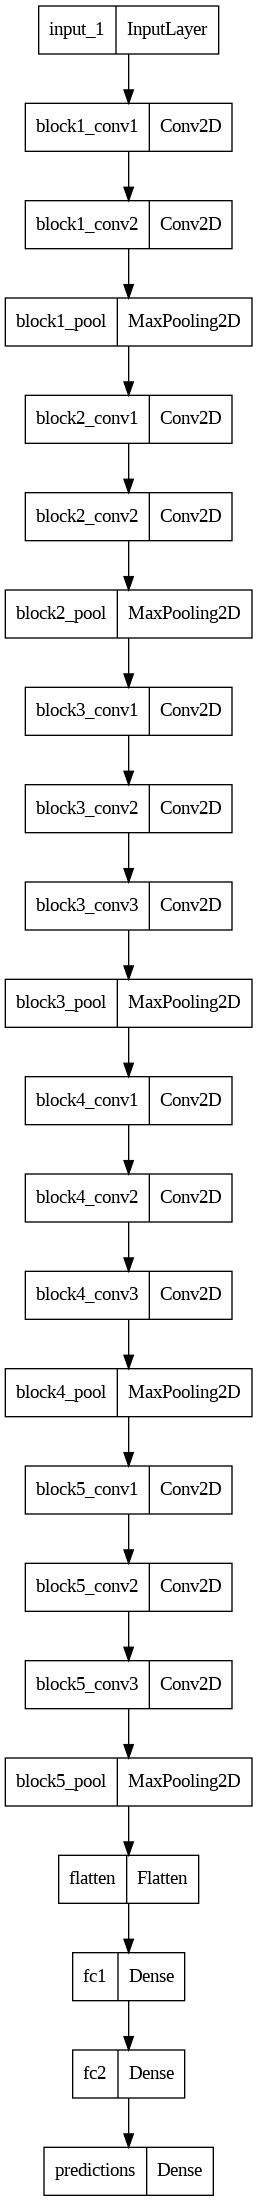

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(vgg16_model)

Now with the model loaded, we can try if it is working. We are going to give it a simple try by letting it classify a simple object (image classification).

### Load and Prepare the Image

We can load the image as pixel data and prepare it to be presented to the network.

Keras provides some tools to help with this step.

First, we can use the `load_img()` function to load the image and resize it to the required size of `224×224` pixels.

I selected this image below since I like cars:


![lambogini](https://pictures.dealer.com/l/lamborghininorthlosangeles/1422/50c89e3ce3c77726547887443c127303x.jpg?impolicy=resize&w=414)

In [ ]:
#### download image
!wget  -O car.jpg 'https://pictures.dealer.com/l/lamborghininorthlosangeles/1422/50c89e3ce3c77726547887443c127303x.jpg?impolicy=resize&w=414'

--2023-06-16 03:40:14--  https://pictures.dealer.com/l/lamborghininorthlosangeles/1422/50c89e3ce3c77726547887443c127303x.jpg?impolicy=resize&w=414
Resolving pictures.dealer.com (pictures.dealer.com)... 23.56.99.59, 23.56.99.19, 2600:1407:a800::1738:a899, ...
Connecting to pictures.dealer.com (pictures.dealer.com)|23.56.99.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37435 (37K) [image/jpeg]
Saving to: ‘car.jpg’

car.jpg             100%[===================>]  36.56K  --.-KB/s    in 0.01s   

2023-06-16 03:40:14 (3.02 MB/s) - ‘car.jpg’ saved [37435/37435]



In [ ]:
from tensorflow.keras.preprocessing.image import load_img
from io import BytesIO
import urllib

img_url = '/content/car.jpg'
car_img = load_img(img_url, target_size=(224, 224))

Next, we can convert the pixels to a NumPy array so that we can work with it in Keras. We can use the `img_to_array()` function for this.

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array

#from keras.preprocessing.image import img_to_array
# convert the image pixels to a numpy array
image = img_to_array(car_img)
image

array([[[198., 203., 209.],
        [203., 206., 213.],
        [207., 210., 217.],
        ...,
        [201., 202., 197.],
        [196., 197., 192.],
        [193., 194., 189.]],

       [[200., 205., 211.],
        [205., 208., 215.],
        [209., 212., 219.],
        ...,
        [201., 202., 197.],
        [197., 198., 193.],
        [193., 194., 189.]],

       [[204., 209., 215.],
        [207., 212., 218.],
        [212., 215., 222.],
        ...,
        [202., 203., 198.],
        [198., 199., 194.],
        [195., 196., 191.]],

       ...,

       [[202., 197., 201.],
        [205., 200., 204.],
        [208., 203., 207.],
        ...,
        [214., 200., 189.],
        [210., 196., 183.],
        [210., 194., 181.]],

       [[199., 194., 198.],
        [203., 198., 202.],
        [205., 200., 204.],
        ...,
        [214., 200., 189.],
        [210., 196., 183.],
        [209., 193., 180.]],

       [[198., 193., 197.],
        [202., 197., 201.],
        [204., 1

The network expects one or more images as input; that means the input array will need to be 4-dimensional: __samples, rows, columns__, and __channels__.

We only have `1` sample (one image). We can reshape the array by calling `reshape()` and adding the extra dimension.

In [ ]:
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

Next, the image pixels need to be prepared in the same way as the ImageNet training data was prepared. We can use the `preprocess_input` function provided with `VGG16`.

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input
# prepare the image for the VGG model
image = preprocess_input(image)

### Make a Prediction

The beauty of using a pre-trained model like `VGG16` is that we do not have to __train__ the model; we can directly use it once the data is prepared to fit its format.

We can call the `predict()` function on the model in order to get a prediction of the probability of the image belonging to each of the `1000` known object types.

In [ ]:
# predict the probability across all output classes
yhat = vgg16_model.predict(image)

1/1 [==============================] - 7s 7s/step


### Interpret Prediction
Keras provides a function to interpret the probabilities called `decode_predictions()`.

It can return a list of classes and their probabilities in case you would like to present the top 3 objects that may be in the photo.

In [ ]:
from tensorflow.keras.applications.vgg16 import decode_predictions
# convert the probabilities to class labels
labels = decode_predictions(yhat)
# retrieve the most likely result, e.g. highest probability
#label = label[0][0]
#print(labels)
# print the classification
for label in labels[0]:
  #print(label[1], label[2])
  print('%s (%.2f%%)' % (label[1], label[2]*100))

35363/35363 [==============================] - 0s 0us/step
sports_car (70.47%)
racer (22.34%)
car_wheel (1.67%)
convertible (1.22%)
limousine (0.66%)


## BONUS CONTENT: Image Augmentation

As discussed above, transfer learning can be used without training. One obvious benefit is that you do not have to train the model.

There are usually multiple reasons to skip the training process. Sometimes, we skip training because it is taking too much time. Some other times, we skip training since we do not have enough training data.

If it is the latter case, besides transfer learning, we can use a technique called __image (_data_) augmentation__.

[Image data augmentation](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/) is a technique that can be used to artificially expand the size of a training dataset by creating modified versions of images in the dataset.

Training deep learning neural network models on more data can result in more skillful models, and the augmentation techniques can create variations of the images that can improve the ability of the fit models to generalize what they have learned to new images.

The Keras deep learning neural network library provides the capability to fit models using image data augmentation via the [ImageDataGenerator class](https://keras.io/preprocessing/image/).

Let's assume we want to build a model to classify sports cars (yes I want to reuse my lambogini image :)), and we do not have enough image data.

The example below will load the photograph as a dataset and use image augmentation to create flipped and rotated versions of the image that can be used to train a convolutional neural network model.

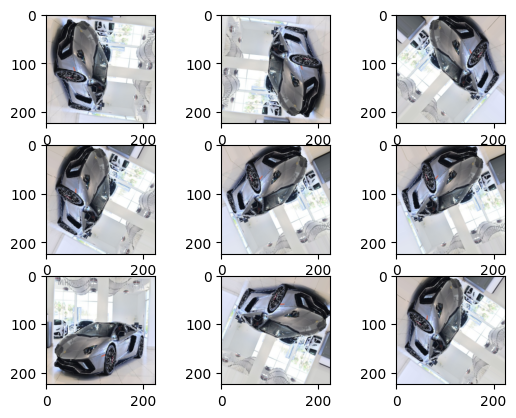

In [ ]:
from numpy import expand_dims
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# convert to numpy array again - we do not want the array prepared for VGG16
data = img_to_array(car_img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
# let's generate 9 images
for i in range(9):
     # define subplot
     plt.subplot(330 + 1 + i)
     # generate batch of images
     batch = it.next()
     # convert to unsigned integers for viewing
     image = batch[0].astype('uint32')
     # plot raw pixel data
     plt.imshow(image)
# show the figure
plt.show()


We can see that the generated images are basically flipped images of the original. Since machines do not know that, it will treat these as different images.

Sometimes, even with enough training data, we would purposely do this since we do not want machine to learn the pattern based on the position/shape.

Other image augmentation techniques including adding noises to images (so they become new images), generative models (e.g. Variational AutoEncoders, Generative Adeversarial Networks) - we will see some of these later in this course.

## Homework

Use the `VGG16` model to classify the first `15` images from the `fashion_mnist` dataset.

__HINT__: you can reuse a lot of codes from part1.

In [ ]:
from tensorflow.keras.datasets import fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
train_images.shape

(60000, 28, 28)

In [ ]:
mnist = train_images[0]

In [ ]:
image = img_to_array(mnist)

In [ ]:
# reshape data for the model
# reshape data for the model
mnist_image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

In [ ]:
mnist_image = preprocess_input(mnist_image)

In [ ]:
# predict the probability across all output classes
mnist_yhat = vgg16_model.predict(mnist_image)

InvalidArgumentError: ignored